<center><img src="https://media-exp1.licdn.com/dms/image/C4E22AQEbIXZiRVkJPQ/feedshare-shrink_2048_1536/0?e=1605139200&v=beta&t=opmJLG_veDflQesF9uJvIhSXbmwPY3DGSlbZo1v-w2k" width="1000"></center>

# SDC Certified Program in Python for Data Science

## Tema 7: Regresión Logística con h2o
### Caso Practico: conjunto de datos de reclamos de señal de telefonía

### Prof. Manuel Sigüeñas, M.Sc.(c) 

[Perfil](https://socialdata-peru.com/learning/teacher2.php)

### Prof. Lenguajes de Programación para Ciencia de Datos / Agile Data Scientists / SCRUMStudy Certified Trainer


[msiguenas@socialdata-peru.com](msiguenas@socialdata-peru.com)

El objetivo es construir un modelo para predecir si en cierta zona habrá o no habrá reclamo de clientes (indicentes). Para ello cada registro contiene información de:

**RSRP:** Nivel de Señal medido en dBm. Generalmente una buena señal es de -70 dBm, y luego se va degradando hacia valores muy malos por debajo de -115 dBm. Mientras más negativo es el valor peor es la señal. Con respecto a este valor, es importante señalar que los **valores perdidos** fueron codificados como **0**.

**Redireccion:** Si una red 4G hay redirecciones o transiciones hacia 3G es un indicativo de que hay problemas en la señal. Esta variable indica la cantidad de conexiones que se van a 3G.

**CQI:** Indicador de la calidad del enlace de radiofrecuencia. Los valores van de 1 a 15. 6 o 7 son valores malos, a partir de 12 hay una buena calidad. A menor calidad hay propensión de mayor reclamos.

**Incidentes:** Variable objetivo, que indica la cantidad de reclamos que existen en la zona. Podemos recodificar 1: Reclamo, 0: No Reclamo. Hay valores 0, nulos, vacíos que habría que limpiar. Adicionalmente hay pocos indicentes (Reclamos) con relación a la cantidad de registros, por lo que habría que como tarea previa (preprocesamiento) realizar un **balanceo de datos**.

In [1]:
#Declarar array
import h2o
import matplotlib.pyplot as plt
import pandas as pd
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.estimator_base import H2OEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator

In [3]:
%matplotlib inline

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 25 mins
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,5 months and 23 days !!!
H2O_cluster_name:,H2O_from_python_SOCIAL_DATA_niynef
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.055 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [3]:
df_py = pd.read_csv("D:/Python/2. Nivel II/7/datos/Grid v1.csv")
df_py.info()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197640 entries, 0 to 197639
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  197640 non-null  object 
 1   Col_Name     197640 non-null  object 
 2   Row_Name     197640 non-null  int64  
 3   rsrp         197640 non-null  float64
 4   incidentes   197640 non-null  int64  
 5   redireccion  197640 non-null  float64
 6   best_server  23318 non-null   object 
 7   cqi          197640 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 12.1+ MB


In [4]:
len(df_py)

197640

In [5]:
df_py = df_py.loc[(df_py['rsrp'] < 0)]

In [6]:
len(df_py)

23103

In [7]:
#Seleccioanr las variables especificas
df_py=df_py.loc[:, ["rsrp", "redireccion", "cqi", "incidentes"]]

In [8]:
df_py.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23103 entries, 14400 to 174240
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rsrp         23103 non-null  float64
 1   redireccion  23103 non-null  float64
 2   cqi          23103 non-null  float64
 3   incidentes   23103 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 902.5 KB


In [9]:
#Verificar si existe algun nulo
na_ratio = ((df_py.isnull().sum() / len(df_py))*100)
print(na_ratio)

rsrp           0.0
redireccion    0.0
cqi            0.0
incidentes     0.0
dtype: float64


In [10]:
#Recodificar la variable predictora en binario
df_py['incidentes']=df_py["incidentes"].replace([2, 3, 4, 5, 6, 7],1)
#Cambiar el tipo de la variable "incidentes" a category
df_py['incidentes'] = df_py['incidentes'].astype('category')

In [11]:
#Importar un dataframe de pandas a uno de H2O
data = h2o.H2OFrame(df_py)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Construir data de entrenamiento y de prueba (test)  

In [12]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [13]:
train, test = data.split_frame(ratios=[0.7],# 70% de las observaciones son entrenamiebnto
                               seed= 2020) #semilla 2020

In [47]:
len(train)

16226

In [48]:
len(test)

6877

## Entrenamiento del Modelo

In [14]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
# predictores del modelo
training_columns = ['rsrp','redireccion','cqi']
# target del modelo
response_column = 'incidentes'
#, standardize = True
glm_model = H2OGeneralizedLinearEstimator(family= "binomial", #familia a la cual pertenece nuestro modelo 
                                          lambda_=0.0001,#lambda
                                          nfolds=10, #validación cruzada - 10
                                          alpha=.5)#criterio de decisión
glm_model.train(training_columns, #etiquetas de los predictores en formato lista
                response_column,  #el target (la variable objetivo)
                training_frame= train) #datos

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [15]:
#AUC
glm_model.auc() #área bajo la curva ROC

0.6673180451800338

In [16]:
#Matriz de Confusión
glm_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08725614189442826: 


,,0,1,Error,Rate
0,0,13593.0,1565.0,0.1032,(1565.0/15158.0)
1,1,772.0,296.0,0.7228,(772.0/1068.0)
2,Total,14365.0,1861.0,0.144,(2337.0/16226.0)


## Desempeño del Modelo con la data de testeo

In [17]:
predict = glm_model.model_performance(test)
#AUC
predict.auc()

0.6576425957224323

In [18]:
predict.accuracy()

[[0.7907508959764559, 0.9370364984731714]]

In [19]:
#Matriz de Confusión
predict.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0754841193216842: 


,,0,1,Error,Rate
0,0,5114.0,1329.0,0.2063,(1329.0/6443.0)
1,1,244.0,190.0,0.5622,(244.0/434.0)
2,Total,5358.0,1519.0,0.2287,(1573.0/6877.0)


## Predicción del Modelo

In [30]:
glm_model.predict(train)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.919649,0.0803512
0,0.93059,0.0694098
0,0.928597,0.0714033
0,0.933867,0.0661332
0,0.917169,0.0828311
0,0.94637,0.0536303
0,0.944135,0.0558649
0,0.936048,0.0639519
0,0.935239,0.0647614
0,0.929434,0.0705658


In [29]:
glm_model.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.92101,0.0789903
0,0.946115,0.0538845
1,0.910466,0.0895339
0,0.928378,0.0716217
0,0.934548,0.0654518
0,0.934605,0.0653948
0,0.922121,0.0778789
0,0.937126,0.0628738
0,0.939042,0.0609583
0,0.947826,0.0521737


In [23]:
type(prob)

h2o.frame.H2OFrame

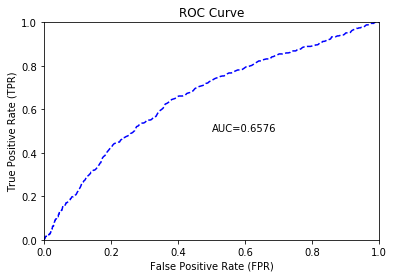

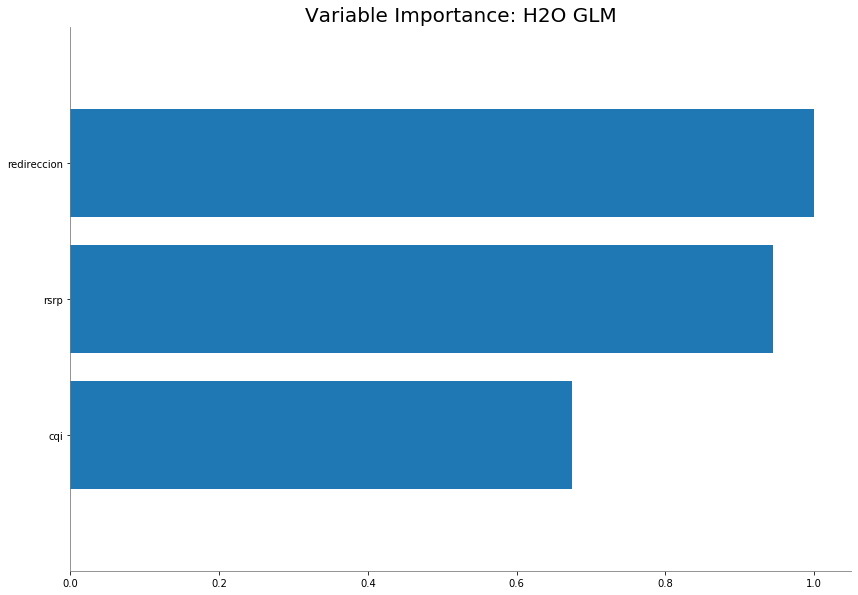

In [55]:
#Generar la curva roc
predict.plot(type = "roc")
#Muestra las variables mas importantes
glm_model.varimp_plot()

In [19]:
h2o.shutdown()#Cerramos la sesion del H2O

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_bd2f closed.
